In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


Epoch 1/100: Train Loss: 2.7384, Train Accuracy: 0.1575, Val Loss: 2.6760, Val Accuracy: 0.1741
Epoch 2/100: Train Loss: 2.0909, Train Accuracy: 0.3237, Val Loss: 2.0185, Val Accuracy: 0.3125
Epoch 3/100: Train Loss: 1.6375, Train Accuracy: 0.4787, Val Loss: 2.0066, Val Accuracy: 0.3839
Epoch 4/100: Train Loss: 1.3444, Train Accuracy: 0.5531, Val Loss: 1.8103, Val Accuracy: 0.4777
Epoch 5/100: Train Loss: 1.0517, Train Accuracy: 0.6581, Val Loss: 2.2640, Val Accuracy: 0.4174
Epoch 6/100: Train Loss: 0.7466, Train Accuracy: 0.7613, Val Loss: 1.7478, Val Accuracy: 0.4665
Epoch 7/100: Train Loss: 0.5526, Train Accuracy: 0.8181, Val Loss: 2.4136, Val Accuracy: 0.4353
Epoch 8/100: Train Loss: 0.3944, Train Accuracy: 0.8775, Val Loss: 1.8109, Val Accuracy: 0.5246
Epoch 9/100: Train Loss: 0.3004, Train Accuracy: 0.9031, Val Loss: 2.3429, Val Accuracy: 0.4710
Epoch 10/100: Train Loss: 0.2419, Train Accuracy: 0.9219, Val Loss: 3.7571, Val Accuracy: 0.3705
Epoch 11/100: Train Loss: 0.1712, Train

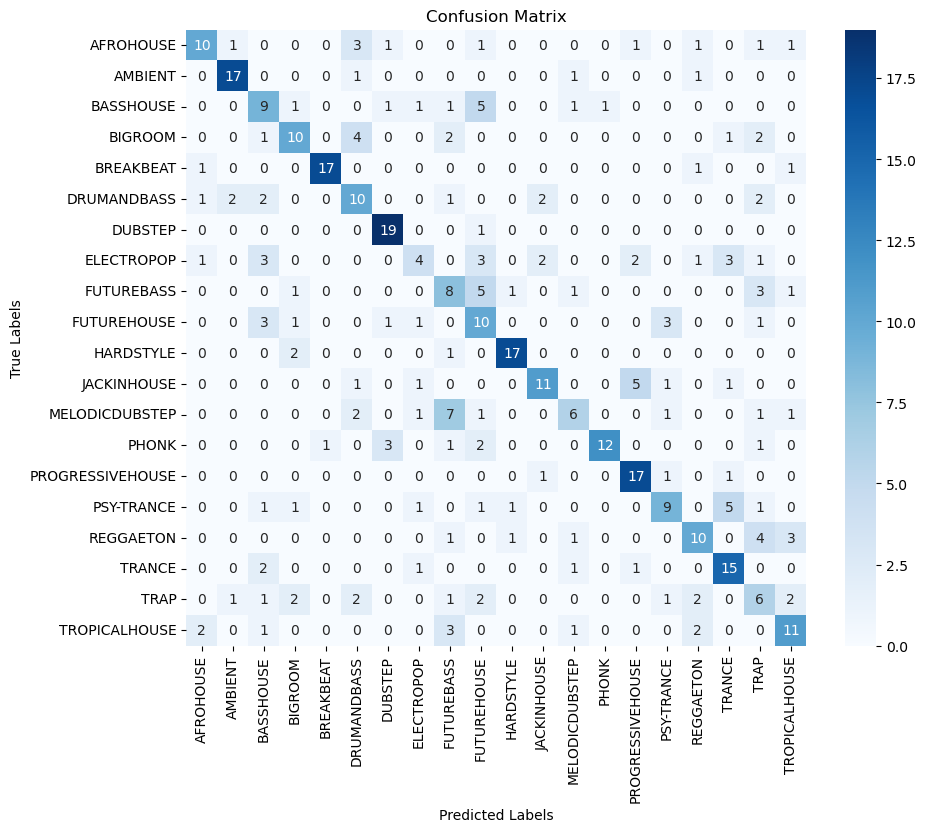

In [5]:
'''
Layers and Components Used
1D Convolutional Layers (conv1, conv2, etc.):

Used for extracting features from the input signal.
The kernel size is 3 with 'same' padding to maintain feature map size.
Batch Normalization Layers (bn1, bn2, etc.):

Applied after each convolution to normalize output and speed up training.
ReLU Activation (relu1, relu2, etc.):

Non-linear activation function used to introduce non-linearity.
Max Pooling Layers (pool1, pool2, etc.):

Reduces feature map size by half, keeping key features while decreasing computational load.
1x1 Convolution Layers for Skip Connections (conv1x1_1, conv1x1_2, conv1x1_3):

Adjusts the dimensions of the skip tensor to match the main path before addition in the residual connections.
Adaptive Average Pooling (gap):

Compresses each feature map to a single value, creating a fixed-size output regardless of input length.
Fully Connected (Dense) Layers (fc1, fc2):

fc1 processes the flattened feature vector from convolutional layers.
fc2 outputs class predictions.
Dropout (dropout):

Regularization layer to prevent overfitting by randomly dropping units during training.
'''


import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Configuration
CONFIG = {
    'batch_size': 64,
    'epochs': 100,
    'initial_lr': 1e-3,
    'weight_decay': 1e-5,
    'validation_split': 0.2,
    'random_state': 42
}

class EDMDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # Convert X to float32
        self.y = torch.tensor(y, dtype=torch.long)     # Labels can be kept as long for classification

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def plot_confusion_matrix(y_true, y_pred, class_names):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot using seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return y_true, y_pred


class CNNResNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNNResNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm1d(128)
        self.conv1x1_1 = nn.Conv1d(64, 128, kernel_size=1)  # 1x1 conv for dimension matching
        self.relu3 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)

        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm1d(256)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding='same')
        self.bn5 = nn.BatchNorm1d(256)
        self.conv1x1_2 = nn.Conv1d(128, 256, kernel_size=1)  # 1x1 conv for dimension matching
        self.relu5 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(2)

        self.conv6 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding='same')
        self.bn6 = nn.BatchNorm1d(512)
        self.relu6 = nn.ReLU()
        self.conv7 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding='same')
        self.bn7 = nn.BatchNorm1d(512)
        self.conv1x1_3 = nn.Conv1d(256, 512, kernel_size=1)  # 1x1 conv for dimension matching
        self.relu7 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(2)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(512, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # First residual block
        skip = self.conv1x1_1(x)  # Adjust skip dimensions
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = 0.5 * x + 0.5 * skip  # Weighted addition
        x = self.relu3(x)
        x = self.pool2(x)

        # Second residual block
        skip = self.conv1x1_2(x)  # Adjust skip dimensions
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = 0.5 * x + 0.5 * skip  # Weighted addition
        x = self.relu5(x)
        x = self.pool3(x)

        # Third residual block
        skip = self.conv1x1_3(x)  # Adjust skip dimensions
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.conv7(x)
        x = self.bn7(x)
        x = 0.5 * x + 0.5 * skip  # Weighted addition
        x = self.relu7(x)
        x = self.pool4(x)

        # Classification head
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def load_and_preprocess_data(train_path, test_path):
    """Load and preprocess the dataset"""
    train_data = pd.read_excel(train_path)
    test_data = pd.read_excel(test_path)
    
    # Combine train and test data for encoding/scaling
    X = pd.concat([
        train_data.drop(columns=['Genre', 'File Name']),
        test_data.drop(columns=['Genre', 'File Name'])
    ])
    y = pd.concat([train_data['Genre'], test_data['Genre']])
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = np.expand_dims(X_scaled, axis=1)
    
    return X_scaled, y_encoded, label_encoder.classes_

def train_model(model, train_loader, val_loader, config):
    """Train the model with error handling and callbacks"""
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=config['initial_lr'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss()

    best_val_accuracy = 0
    for epoch in range(config['epochs']):
        # Train
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_accuracy += (outputs.argmax(1) == labels).float().mean()
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)

        # Validate
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_accuracy += (outputs.argmax(1) == labels).float().mean()
        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)

        print(f"Epoch {epoch+1}/{config['epochs']}: "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    return best_val_accuracy

def main():
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load and preprocess data
    X_scaled, y_encoded, class_names = load_and_preprocess_data(
        r'C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx',
        r'C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx'
    )
    
    # Split data into training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded,
        test_size=CONFIG['validation_split'],
        random_state=CONFIG['random_state'],
        stratify=y_encoded
    )
    
    # Create PyTorch dataset and dataloader
    train_dataset = EDMDataset(X_train, y_train)
    test_dataset = EDMDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
    
    # Create and train the model
    model = CNNResNet(input_shape=(1, X_train.shape[1]), num_classes=len(class_names)).to(device)
    best_val_accuracy = train_model(model, train_loader, test_loader, CONFIG)
    print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}")
    
    # Evaluate the model on test data and plot confusion matrix
    y_true, y_pred = evaluate_model(model, test_loader, device)
    plot_confusion_matrix(y_true, y_pred, class_names)

if __name__ == "__main__":
    main()

TESTING

TESTING 2ND MODEL OF MORE PRECISION

Using device: cpu
Epoch 1/150: Train Loss: 2.6672, Train Accuracy: 0.2256, Val Loss: 2.3666, Val Accuracy: 0.3966, LR: 0.000195
Epoch 2/150: Train Loss: 2.1763, Train Accuracy: 0.4331, Val Loss: 1.9106, Val Accuracy: 0.5072, LR: 0.000181
Epoch 3/150: Train Loss: 1.9580, Train Accuracy: 0.5088, Val Loss: 1.8432, Val Accuracy: 0.4952, LR: 0.000159
Epoch 4/150: Train Loss: 1.7940, Train Accuracy: 0.5550, Val Loss: 1.7894, Val Accuracy: 0.5337, LR: 0.000131
Epoch 5/150: Train Loss: 1.6585, Train Accuracy: 0.6112, Val Loss: 1.7255, Val Accuracy: 0.5673, LR: 0.000101
Epoch 6/150: Train Loss: 1.5969, Train Accuracy: 0.6419, Val Loss: 1.7210, Val Accuracy: 0.5673, LR: 0.000070
Epoch 7/150: Train Loss: 1.4872, Train Accuracy: 0.6844, Val Loss: 1.6540, Val Accuracy: 0.5793, LR: 0.000042
Epoch 8/150: Train Loss: 1.4253, Train Accuracy: 0.7069, Val Loss: 1.6393, Val Accuracy: 0.5962, LR: 0.000020
Epoch 9/150: Train Loss: 1.3875, Train Accuracy: 0.7256, Val Loss: 1.6212, Val Accuracy: 0.6082, LR: 0

C:\Users\ashut\AppData\Local\Temp\ipykernel_19392\1627920176.py:318: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


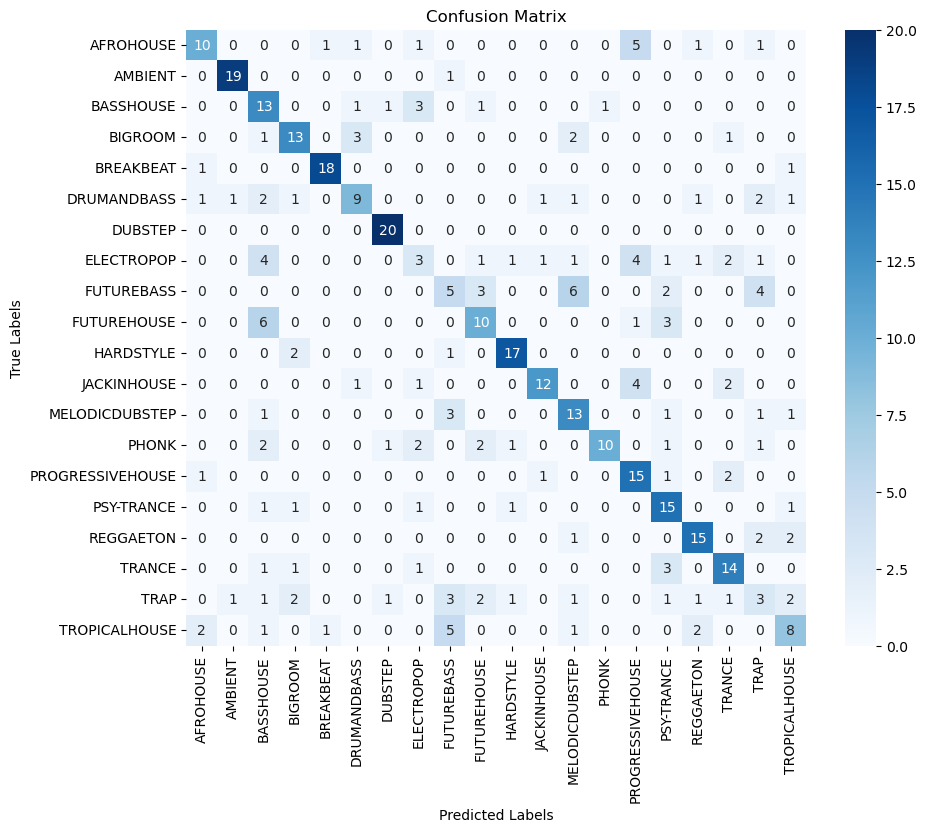

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F

# Enhanced Configuration
CONFIG = {
    'batch_size': 32,  # Reduced batch size for better generalization
    'epochs': 150,     # Increased epochs
    'initial_lr': 2e-4,  # Lower learning rate
    'min_lr': 1e-6,    # Minimum learning rate for scheduler
    'weight_decay': 1e-4,  # Increased weight decay
    'validation_split': 0.2,
    'random_state': 42,
    'dropout_rate': 0.3,  # Reduced dropout
    'label_smoothing': 0.1  # Label smoothing factor
}

class EDMDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.augment and torch.rand(1) < 0.5:
            # Add random noise
            noise = torch.randn_like(x) * 0.05
            x = x + noise
            
            # Random scaling
            scale = torch.rand(1) * 0.2 + 0.9  # scale between 0.9 and 1.1
            x = x * scale

        return x, y

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool1d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1)
        return x * y.expand_as(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, 
                              stride=stride, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 
                              padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
        
        self.se = SEBlock(out_channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ImprovedCNNResNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(ImprovedCNNResNet, self).__init__()
        
        # Initial layers
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual blocks
        self.layer1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64)
        )
        
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128)
        )
        
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256)
        )
        
        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512)
        )
        
        # Global pooling and classification head
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(512, 512)
        self.dropout1 = nn.Dropout(CONFIG['dropout_rate'])
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(CONFIG['dropout_rate'])
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x

def load_and_preprocess_data(train_path, test_path):
    """Enhanced data preprocessing"""
    train_data = pd.read_excel(train_path)
    test_data = pd.read_excel(test_path)
    
    X = pd.concat([
        train_data.drop(columns=['Genre', 'File Name']),
        test_data.drop(columns=['Genre', 'File Name'])
    ])
    y = pd.concat([train_data['Genre'], test_data['Genre']])
    
    # Label encoding
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Combine StandardScaler and MinMaxScaler for better feature scaling
    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler()
    
    X_scaled = standard_scaler.fit_transform(X)
    X_scaled = minmax_scaler.fit_transform(X_scaled)
    X_scaled = np.expand_dims(X_scaled, axis=1)
    
    return X_scaled, y_encoded, label_encoder.classes_

def train_model(model, train_loader, val_loader, config):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Optimizer with gradient clipping
    optimizer = optim.AdamW(model.parameters(), 
                           lr=config['initial_lr'],
                           weight_decay=config['weight_decay'])
    
    # Cosine annealing scheduler with warm restarts
    scheduler = CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,  # Initial restart interval
        T_mult=2,  # Multiply T_0 by this factor after each restart
        eta_min=config['min_lr']  # Minimum learning rate
    )
    
    # Loss function with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

    best_val_accuracy = 0
    patience = 20  # Early stopping patience
    patience_counter = 0
    
    for epoch in range(config['epochs']):
        # Train
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
            train_accuracy += (outputs.argmax(1) == labels).float().mean()
            
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)

        # Validate
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_accuracy += (outputs.argmax(1) == labels).float().mean()
                
        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)

        # Learning rate scheduling
        scheduler.step()

        print(f"Epoch {epoch+1}/{config['epochs']}: "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
              f"LR: {scheduler.get_last_lr()[0]:.6f}")

        # Save best model and handle early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    return best_val_accuracy

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load and preprocess data
    X_scaled, y_encoded, class_names = load_and_preprocess_data(
        r'C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx',
        r'C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx'
    )
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded,
        test_size=CONFIG['validation_split'],
        random_state=CONFIG['random_state'],
        stratify=y_encoded
    )
    
    # Create datasets with augmentation for training
    train_dataset = EDMDataset(X_train, y_train, augment=True)
    test_dataset = EDMDataset(X_test, y_test, augment=False)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=4 if torch.cuda.is_available() else 0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=4 if torch.cuda.is_available() else 0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    # Create and train model
    model = ImprovedCNNResNet(input_shape=(1, X_train.shape[1]), num_classes=len(class_names)).to(device)
    best_val_accuracy = train_model(model, train_loader, test_loader, CONFIG)
    print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}")
    
    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pth'))
    y_true, y_pred = evaluate_model(model, test_loader, device)
    plot_confusion_matrix(y_true, y_pred, class_names)

if __name__ == "__main__":
    main()